### Churn Analysis Exercise Notebook 1 of 2

In [5]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None  # default='warn'

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

# regular expression support
import re
# will be used for time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

Helper functions for data extraction and feature generation.

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 500, "display.max_columns", 100): 
        display(df)

In [7]:
def add_datepart(df, fldname, drop=False, time=False):
    """ Fastai library function - add_datepart converts a column of df from a datetime64 to 
      many columns containing the information from the date. This applies changes inplace.  
      
      Parameters:
      -----------
      df: A pandas data frame. df gain several new columns.
      fldname: A string that is the name of the date column you wish to expand.
      If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
      drop: If true then the original date column will be removed.
      time: If true time features: Hour, Minute, Second will be added.
      """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
 
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [8]:
def add_rolled_up_features(df_txs, df_churn_recs, mean=False, variance=False, rsi=False, aggregate =False, sales_delta=False):
    """ create rolled_up features for classification analysis
      Returns a dataframe with trend features that can include the following: 
       * mean sales by period
       * relative strength index by period
       * total ales by period
       * sales delta by period
       
      The periods include:
       * previous 3 months 
       * previous 6 months 
       * previous 12 months 
    """
    
    df_to_classify = pd.DataFrame()
    df_to_classify["supplier_key"] = pd.Series(df_txs["supplier_key"].unique())
    df_to_classify.set_index("supplier_key", inplace=True)
    
    #use monthly sales data to build the rolled_up features we want
    sales_data_by_month = df_txs.groupby(["supplier_key", \
                                          pd.Grouper(key="report_date",freq='M')])["ordered_product_sales"].sum().reset_index()
    
    if mean:
        add_mean_trend(df_to_classify, sales_data_by_month)

    if rsi:
        add_relative_strength_index(df_to_classify, df_txs)    

    if aggregate:
        add_agg_trend(df_to_classify, sales_data_by_month)
        
    if sales_delta:
        add_sales_delta(df_to_classify, sales_data_by_month)

    if variance:
        #todo - it would be interesting to cluster the clients into segmenats and consider a segment-wide variance value
        pass
          
    #add the churn flag to the rolled-up dataframe 
    churned_ids = df_churn["supplier_key"].tolist()
    df_to_classify["churned"] = np.in1d(df_to_classify.index.values, churned_ids)
    df_to_classify["churned"] = df_to_classify["churned"].replace({True: 'Yes', False: 'No'})
        
    return df_to_classify

In [9]:
def add_mean_trend(df_to_classify, sales_data_by_month):
    """ 
    Generates rolled-up mean values for ordered_product_sales.
    These value are added to the dataframe to be used for classification.
    """
    
    mean_dict_3 = {}
    mean_dict_6 = {}
    mean_dict_year = {}
    mean_dict_total = {}
    sorted_groups = sales_data_by_month.groupby(["supplier_key"])
    for key, group in sorted_groups:
        #take 3,6,12 months of data
        mean_dict_3[key] =  group["ordered_product_sales"].tail(3).mean()
        mean_dict_6[key] = group["ordered_product_sales"].tail(6).mean()
        mean_dict_year[key] = group["ordered_product_sales"].tail(12).mean()
        mean_dict_total[key] = group["ordered_product_sales"].mean()

    df_to_classify["3_month_mean_sales"] = pd.Series(mean_dict_3)
    df_to_classify["6_month_mean_sales"] = pd.Series(mean_dict_6)
    df_to_classify["12_month_mean_sales"] = pd.Series(mean_dict_year)
    df_to_classify["total_mean_sales"] = pd.Series(mean_dict_total)
    

In [10]:
def add_sales_delta(df_to_classify, sales_data_by_month):
    """
    Generate 3_month_delta - % change in sales between last 3 months and previous 3 months
    6_month_delta - % change in sales between last 6 months and previous 6 months
    1_year_delta - % change in sales between last year and previous year sales
    Note delta can be +ive or -ive and is calculated as:
    ((current_period - previous_period) / previous_period) * 100
    These value are added to the dataframe to be used for classification.
    """
    agg_dict_3 = {}
    agg_dict_6 = {}
    agg_dict_year = {}
    agg_dict_total = {}
    
    sorted_groups = sales_data_by_month.groupby(["supplier_key"])
    for key, group in sorted_groups:
        #take 24 months of data - note I have checked that 24 months data exist for all suppliers
        sales_data = group["ordered_product_sales"].tail(24)    
        
        #there are many records with 0 values so handle this
        agg_dict_3[key] = safe_div((sum(sales_data[21:]) - sum(sales_data[18:21])), sum(sales_data[18:21])) * 100
        agg_dict_6[key] = safe_div((sum(sales_data[18:]) - sum(sales_data[12:18])), sum(sales_data[12:18])) * 100
        agg_dict_year[key] = safe_div((sum(sales_data[12:]) - sum(sales_data[0:12])), sum(sales_data[0:12])) * 100
        
    df_to_classify["3_month_sales_change"] = pd.Series(agg_dict_3)
    df_to_classify["6_month_sales_change"] = pd.Series(agg_dict_6)
    df_to_classify["12_month_sales_change"] = pd.Series(agg_dict_year)
    

In [11]:
def safe_div(x,y):
    """
    helper function used by add_sales_delta
    handles divide by 0 events
    """
    if y==0: return 0
    return x/y


In [12]:
def train_cats(df):
    """Fastai library function - change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    """
    for n,c in df.items():
        if is_string_dtype(c): 
            df[n] = c.astype('category').cat.as_ordered()

In [13]:
def add_agg_trend(df_to_classify, sales_data_by_month):
    """ 
    Generates rolled-up total values for ordered_product_sales.
    These value are added to the dataframe to be used for classification.
    """  
    agg_dict_3 = {}
    agg_dict_6 = {}
    agg_dict_year = {}
    agg_dict_total = {}
    sorted_groups = sales_data_by_month.groupby(["supplier_key"])
    for key, group in sorted_groups:
        agg_dict_3[key] =  group["ordered_product_sales"].tail(3).sum()
        agg_dict_6[key] = group["ordered_product_sales"].tail(6).sum()
        agg_dict_year[key] = group["ordered_product_sales"].tail(12).sum()
        agg_dict_total[key] = group["ordered_product_sales"].sum()

    df_to_classify["3_month_total_sales"] = pd.Series(agg_dict_3)
    df_to_classify["6_month_total_sales"] = pd.Series(agg_dict_6)
    df_to_classify["12_month_total_sales"] = pd.Series(agg_dict_year)
    df_to_classify["total_sales"] = pd.Series(agg_dict_total)
    

In [14]:
def add_variance_trend(tx_groups):
    """ Returns a pandas series containing the variance of ordered_product_sales
    """
    dict_var = {}
    for key, group in tx_groups:
        dict_var[key] =  group["ordered_product_sales"].var()

    return dict_var

In [15]:
def add_relative_strength_index(df_to_classify, df_txs ):
    """ 
    Generates RSI values for ordered_product_sales. RSI measures the velocity and magnitude of 
    directional price movements. It is usually used in technical share price analysis. Here I adapt 
    it for analysing trends in ordered_product_sales. This is a bit experimental but should be sound over
    shorter time periods. Note that I use an exponential weighted average (EWMA) rather than w classical mean value here.
    This results in a rolled-up trend metric that is more responsive to recent variations in ordered_product_sales.
    This responsiveness is shown in plots later in this notebook.
    3,6,12 month RSI index values are calculated and added to the dataframe for classification.
    RSI is calculated as: RSI = 100 - 100/(1 + RS), 
    where RS is the ratio of: (EWMA of upward movements)/ (EWMA of downward movements).
    
    Returns 3,6 and 12 months RSI.
    """
    rsi_dict_3 = {}
    rsi_dict_6 = {}
    rsi_dict_12 = {}
    sorted_groups = df_txs.groupby(["supplier_key"])
    for key,group in sorted_groups:
        #3 months rsi - 90 days sales
        vals = group["ordered_product_sales"].head(90).ewm(span=30, ignore_na=True).mean()
        vals_delta = vals.diff()
        neg = vals_delta[vals_delta < 0].sum()/len(vals_delta)
        pos = vals_delta[vals_delta > 0].sum()/len(vals_delta)
        rs=abs(pos/neg)
        rsi = 100 - (100/(1+rs))
        rsi_dict_3[key] = rsi
        
        #6 months rsi = 180 days sales
        vals = group["ordered_product_sales"].head(180).ewm(span=30, ignore_na=True).mean()
        vals_delta = vals.diff()
        neg = vals_delta[vals_delta < 0].sum()/len(vals_delta)
        pos = vals_delta[vals_delta > 0].sum()/len(vals_delta)
        rs=abs(pos/neg)
        rsi = 100 - (100/(1+rs))
        rsi_dict_6[key] = rsi
        
        #12 months rsi = 180 days sales
        vals = group["ordered_product_sales"].head(360).ewm(span=30, ignore_na=True).mean()
        vals_delta = vals.diff()
        neg = vals_delta[vals_delta < 0].sum()/len(vals_delta)
        pos = vals_delta[vals_delta > 0].sum()/len(vals_delta)
        rs=abs(pos/neg)
        rsi = 100 - (100/(1+rs))
        rsi_dict_12[key] = rsi
        
        
    df_to_classify["3_month_rsi"] = pd.Series(rsi_dict_3)
    df_to_classify["6_month_rsi"] = pd.Series(rsi_dict_6)
    df_to_classify["12_month_rsi"] = pd.Series(rsi_dict_12)
    

In [16]:
def tx_date_contiguity(df):
    """ using extraced datetime flds generate contiguity infrmation for all sets of txs grouped by 
    suppplier_key.
    Returns a dataframe with supplier_records as column names and contiguity records as rows.
    Cell values will show the number of days since the previous sales transaction.
    For example if we have daily transaction records for a supplier over a given time-period then the 
    cell values would all be 1.0. If we have a negative value then it indicates that the records have not 
    been provided in chronological order.
    Parameters:
    -----------
    df: A pandas DataFrame object
    """
    groups = df.groupby(["supplier_key"])
    times_dict = {}
    for key, group in groups:
        #note that report_Elapsed is the difference in seconds from tx n and tx n-1.
        times_dict[key] = (group["report_Elapsed"].diff()/-86400).tolist()
           
    df_times = pd.DataFrame.from_dict(times_dict,orient='index').transpose()
    df_times.drop(df_times.index[0], inplace=True)
    return df_times

In [17]:
def tx_date_sort(df):
    """
    Sort the dataframe in chronological order.
    Parameters:
    -----------
    df: A pandas dataframe.
    """
    
    df_time_sorted = pd.DataFrame()
    #first group the tx records by supplier_keys
    groups = df_sales.groupby(["supplier_key"])
    for key, group in group:
        group.sort_values(by="report_date", inplace=True)
    
    df.sort_values(by='date', inplace=True)
    

# 1. Extract and Clean Data


In [18]:
# Load churn data from CSV
df_churn = pd.read_csv('data/churn_data.csv', index_col=0, sep = ';', parse_dates=["churn_date"])
# Load seller performance data from CSV
df_sales = pd.read_csv('data/seller_performance_data.csv', index_col=0, sep = ';', parse_dates=["report_date"])

In [19]:
# Dataframe dimensions
print("Churn data dimensions:" , df_churn.shape, "Seller data dimensions:", df_sales.shape)

Churn data dimensions: (141, 2) Seller data dimensions: (278975, 7)


In [20]:
# Column datatypes
df_churn.dtypes

supplier_key            object
churn_date      datetime64[ns]
dtype: object

In [21]:
# we will convert the ordered_product_sales and ordered_product_sales_b2b to a float type
df_sales.dtypes

supplier_key                         object
report_date                  datetime64[ns]
ordered_product_sales                object
ordered_product_sales_b2b            object
units_ordered                         int64
units_ordered_b2b                     int64
units_refunded                        int64
dtype: object

In [22]:
# change the dtypes from object to float
df_sales["ordered_product_sales"] = df_sales["ordered_product_sales"].replace({',':'.'},regex=True).apply(pd.to_numeric,1)
df_sales["ordered_product_sales_b2b"] = df_sales["ordered_product_sales_b2b"].replace({',':'.'},regex=True).apply(pd.to_numeric,1)

In [23]:
display_all(df_churn.T)

1    \
supplier_key  031a13f1-5488-4ef8-a2fa-e55bb894c44e   
churn_date                     2018-01-18 00:00:00   

                                               2    \
supplier_key  03d96d8a-7178-4f7d-a8f2-8ef1a643ecd5   
churn_date                     2016-12-09 00:00:00   

                                               3    \
supplier_key  0574ad4e-5331-4e0b-9dd5-70d8fd3ba01b   
churn_date                     2018-01-19 00:00:00   

                                               4    \
supplier_key  073941ba-16e0-4a1f-825e-1cd94b9d50cb   
churn_date                     2017-04-27 00:00:00   

                                               5    \
supplier_key  082ba7d5-7b68-46e3-8a53-fc4d52104e28   
churn_date                     2018-10-02 00:00:00   

                                               6    \
supplier_key  08bf0731-752f-4f9c-ad76-472e3d471b8f   
churn_date                     2017-06-29 00:00:00   

                                               7    \
supplier_key  08c5c6b8-d943-4c6e-8fca-8a9671c3f05f   
churn_date                     2017-12-02 00:00:00   

                                               8    \
supplier_key  0921b1ae-2962-459b-9eaa-647bbbdf50a4   
churn_date                     2018-02-20 00:00:00   

                                               9    \
supplier_key  093222f2-0030-4b9f-833e-b1395b1cf824   
churn_date                     2016-02-03 00:00:00   

                                               10   \
supplier_key  098551dd-ab8c-490b-992b-f7592765c76d   
churn_date                     2018-05-26 00:00:00   

                                               11   \
supplier_key  0ae8714c-f0fb-4f71-a23a-e9f3c4f327b9   
churn_date                     2018-09-28 00:00:00   

                                               12   \
supplier_key  0d689beb-d210-44c7-a12c-ff1da48f71d5   
churn_date                     2017-02-21 00:00:00   

                                               13   \
supplier_key  0f76e21d-c38b-4235-8b48-876529f13dbf   
churn_date                     2018-06-01 00:00:00   

                                               14   \
supplier_key  10e9d762-4729-4460-92c8-7e20bfd25ccf   
churn_date                     2018-03-30 00:00:00   

                                               15   \
supplier_key  12e47200-484d-46b0-8d7c-fa30e9084a58   
churn_date                     2017-01-17 00:00:00   

                                               16   \
supplier_key  1536b286-213e-4057-be96-e48048eb5685   
churn_date                     2017-07-14 00:00:00   

                                               17   \
supplier_key  16ce90fe-c6e1-434a-a546-57873640f79a   
churn_date                     2018-08-09 00:00:00   

                                               18   \
supplier_key  18755f48-b8e3-4458-a2f2-166691d30dab   
churn_date                     2017-09-05 00:00:00   

                                               19   \
supplier_key  19d6ecec-e16c-458e-84e9-8e01ecf45e5b   
churn_date                     2017-05-11 00:00:00   

                                               20   \
supplier_key  2403879f-ce81-4964-805f-a57ec8320e7c   
churn_date                     2018-08-01 00:00:00   

                                               21   \
supplier_key  2606d53c-8d29-4a63-851e-1b622ba24070   
churn_date                     2018-11-09 00:00:00   

                                               22   \
supplier_key  266eaa75-d7f0-42f5-952b-fc0bb1a19181   
churn_date                     2018-11-16 00:00:00   

                                               23   \
supplier_key  2a833091-a3f1-4bf6-ad56-8405c2da81dc   
churn_date                     2018-07-24 00:00:00   

                                               24   \
supplier_key  2c624e3d-30a6-4328-9767-c78100ab26c7   
churn_date                     2017-07-06 00:00:00   

                                               25   \
supplier_key  2d8ed3f1-c1f9-426e-be37-43dcd558fe6c   
churn_date                 

In [24]:
display_all(df_sales.T)

1       \
supplier_key               00179d2b-e696-4536-b530-e25ed838fae6   
report_date                                 2018-10-24 00:00:00   
ordered_product_sales                                    1651.5   
ordered_product_sales_b2b                                     0   
units_ordered                                               214   
units_ordered_b2b                                             0   
units_refunded                                                0   

                                                         2       \
supplier_key               00179d2b-e696-4536-b530-e25ed838fae6   
report_date                                 2018-10-23 00:00:00   
ordered_product_sales                                   1728.16   
ordered_product_sales_b2b                                     0   
units_ordered                                               193   
units_ordered_b2b                                             0   
units_refunded                                                0   

                                                         3       \
supplier_key               00179d2b-e696-4536-b530-e25ed838fae6   
report_date                                 2018-10-22 00:00:00   
ordered_product_sales                                   2115.83   
ordered_product_sales_b2b                                     0   
units_ordered                                               188   
units_ordered_b2b                                             0   
units_refunded                                                0   

                                                         4       \
supplier_key               00179d2b-e696-4536-b530-e25ed838fae6   
report_date                                 2018-10-21 00:00:00   
ordered_product_sales                                   1304.69   
ordered_product_sales_b2b                                     0   
units_ordered                                               160   
units_ordered_b2b                                             0   
units_refunded                                                0   

                                                         5       \
supplier_key               00179d2b-e696-4536-b530-e25ed838fae6   
report_date                                 2018-10-20 00:00:00   
ordered_product_sales                                    536.08   
ordered_product_sales_b2b                                     0   
units_ordered                                                86   
units_ordered_b2b                                             0   
units_refunded                                                0   

                                                         6       \
supplier_key               00179d2b-e696-4536-b530-e25ed838fae6   
report_date                                 2018-10-19 00:00:00   
ordered_product_sales                                    1124.3   
ordered_product_sales_b2b                                     0   
units_ordered                                               152   
units_ordered_b2b                                             0   
units_refunded                                                0   

                                                         7       \
supplier_key               00179d2b-e696-4536-b530-e25ed838fae6   
report_date                                 2018-10-18 00:00:00   
ordered_product_sales                                   1253.47   
ordered_product_sales_b2b                                     0   
units_ordered                                               202   
units_ordered_b2b                                             0   
units_refunded                                                0   

                                                         8       \
supplier_key               00179d2b-e696-4536-b530-e25ed838fae6   
report_date                                 2018-10-17 00:00:00   
ordered_product_sales                                   1067.48   
ordered_product_sales_b2b     

In [25]:
df_sales["supplier_key"].nunique()

284

The churn_data.csv file contains records of 141 customers that have churned.
The seller_performance_data.csv file contains sales records of 284 clients.
 

In [26]:
#supplier_key values are lengthy and so for the purposes of this exercise are masked
keys = df_sales["supplier_key"].unique().tolist()
values = list(range(1, len(keys) + 1))
supplier_key_mask = dict(zip(keys, values))
df_sales["supplier_key"]=df_sales["supplier_key"].apply(supplier_key_mask.get)

In [27]:
#apply the same mask to the churn data dataframe
df_churn["supplier_key"] = df_churn["supplier_key"].apply(supplier_key_mask.get)

In [28]:
# we have 14 rows in churn_data.csv with no seller_performance_data.
df_churn.isnull().sum()

supplier_key    14
churn_date       0
dtype: int64

In [29]:
#drop these 14 mismatched_records and convert supplier_keys to int to conform with df_sales formatting
df_churn.dropna(inplace=True)
df_churn["supplier_key"] = df_churn["supplier_key"].astype(int)

In [30]:
df_sales.shape

(278975, 7)

**Some supplier_key records have zero valued transactions after the churn date.
In some case there are months of zero valued transaction recorded after the churn date.
These would confound our rolled-up values and so must be removed.**

In [31]:
#drop all rows for a supplier_key after the churn date where it exists
for a,b in zip(df_churn["supplier_key"], df_churn["churn_date"]):    
    df_sales.drop(df_sales[(df_sales["supplier_key"] == a) & (df_sales["report_date"] > str(b.date()))].index, inplace=True)


In [32]:
#we have dropped c. 6000 rows of zero valued records after the churn date.
df_sales.shape

(272655, 7)

In [33]:
df_churn.nunique()

supplier_key    127
churn_date      117
dtype: int64

In [34]:
#there are no missing values in this dataset as seen here
df_sales.isnull().sum()/df_sales.shape[0]*100

supplier_key                 0.0
report_date                  0.0
ordered_product_sales        0.0
ordered_product_sales_b2b    0.0
units_ordered                0.0
units_ordered_b2b            0.0
units_refunded               0.0
dtype: float64

In [30]:
#The percentage of zero-valued entries in columns is high as shown here
print(df_sales[df_sales == 0].count(axis=0)/len(df_sales.index))

supplier_key                 0.000000
report_date                  0.000000
ordered_product_sales        0.445989
ordered_product_sales_b2b    0.924381
units_ordered                0.445989
units_ordered_b2b            0.924381
units_refunded               0.887176
dtype: float64


In [31]:
(df_sales.iloc[:,2:]==0).sum(axis=0)

ordered_product_sales        121601
ordered_product_sales_b2b    252037
units_ordered                121601
units_ordered_b2b            252037
units_refunded               241893
dtype: int64

**44% of our data is zero-valued.
Does this mean that there were no sales on these dates?
It could also be simply that sales reporting and data generation are not necessarily linked?
This effect is dampened by the fact that we are going to use aggregated values for analysis and so I leave it as it is for now.**

In [32]:
((df_sales.iloc[:,2:]==0).sum(axis=1) == 5).sum()/len(df_sales.index)

0.4429443802607691

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. Expanding date-time into these additional fields allows trend/cyclical behavior to be captured as a function of time. These new fields are added to the original dataframe.

In [35]:
add_datepart(df_sales, 'report_date')
add_datepart(df_churn, 'churn_date')

In [36]:
df_sales.dtypes, df_churn.dtypes

(supplier_key                          int64
 report_date                  datetime64[ns]
 ordered_product_sales               float64
 ordered_product_sales_b2b           float64
 units_ordered                         int64
 units_ordered_b2b                     int64
 units_refunded                        int64
 report_Year                           int64
 report_Month                          int64
 report_Week                           int64
 report_Day                            int64
 report_Dayofweek                      int64
 report_Dayofyear                      int64
 report_Is_month_end                    bool
 report_Is_month_start                  bool
 report_Is_quarter_end                  bool
 report_Is_quarter_start                bool
 report_Is_year_end                     bool
 report_Is_year_start                   bool
 report_Elapsed                        int64
 dtype: object, supplier_key                       int64
 churn_date                datetime64[ns]
 

** Summary statistics for numerical variables. *ordered_product_sales* will be the focus of our analysis.**
**The large difference between the  99% percentile range and the maximum value is evidence of large outliers.** 

In [37]:
df_sales.describe(percentiles=[.25, .5, .75, .99], include=[np.number])

supplier_key  ordered_product_sales  ordered_product_sales_b2b  \
count  272655.000000          272655.000000              272655.000000   
mean      143.232341             947.204684                  28.236574   
std        81.664580            4949.081179                 334.565338   
min         1.000000               0.000000                   0.000000   
25%        73.000000               0.000000                   0.000000   
50%       143.000000              39.950000                   0.000000   
75%       215.000000             412.025000                   0.000000   
99%       281.000000           19083.576200                 503.944600   
max       284.000000          307322.450000               16839.220000   

       units_ordered  units_ordered_b2b  units_refunded    report_Year  \
count  272655.000000      272655.000000   272655.000000  272655.000000   
mean       37.748429           1.058510        0.760764    2016.708635   
std       273.940357          14.912902        7.928865       0.953120   
min         0.000000           0.000000       -1.000000    2014.000000   
25%         0.000000           0.000000        0.000000    2016.000000   
50%         2.000000           0.000000        0.000000    2017.000000   
75%        14.000000           0.000000        0.000000    2017.000000   
99%       570.460000          12.000000       16.000000    2018.000000   
max     24333.000000        1867.000000     1582.000000    2018.000000   

        report_Month    report_Week     report_Day  report_Dayofweek  \
count  272655.000000  272655.000000  272655.000000     272655.000000   
mean        6.627430      27.057736      15.780367          3.001111   
std         3.405894      14.892083       8.806308          1.998847   
min         1.000000       1.000000       1.000000          0.000000   
25%         4.000000      14.000000       8.000000          1.000000   
50%         7.000000      27.000000      16.000000          3.000000   
75%        10.000000      40.000000      23.000000          5.000000   
99%        12.000000      52.000000      31.000000          6.000000   
max        12.000000      53.000000      31.000000          6.000000   

       report_Dayofyear  report_Elapsed  
count     272655.000000    2.726550e+05  
mean         186.412074    1.490024e+09  
std          104.215559    2.935916e+07  
min            1.000000    1.419034e+09  
25%           97.000000    1.468368e+09  
50%          189.000000    1.490314e+09  
75%          276.000000    1.513469e+09  
99%          362.000000    1.542067e+09  
max          366.000000    1.543622e+09

**The boxplot below shows that the *ordered_product_sales* distribution is very stretched.**

Text(0.5,1,'Ordered_product_sales distribution')

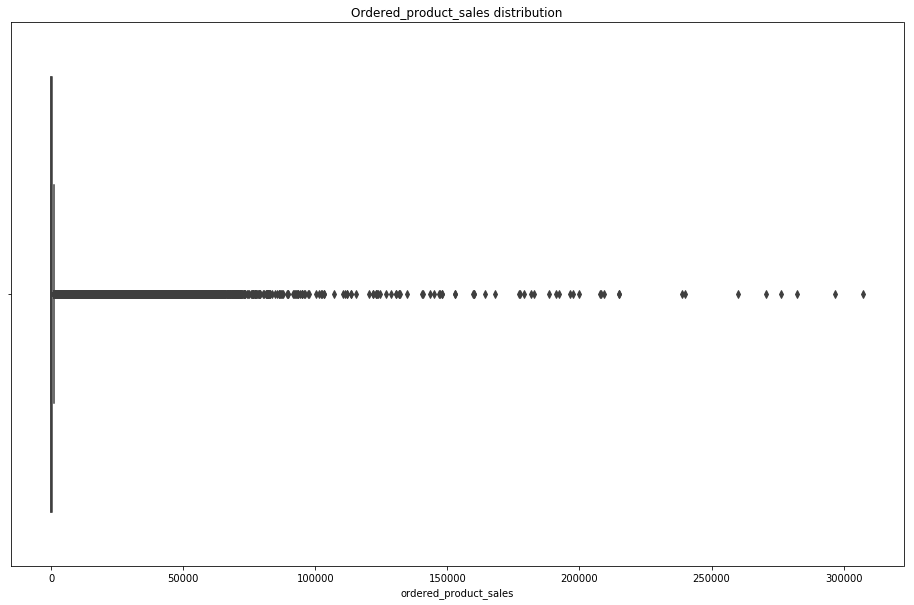

In [38]:
 fig= plt.gcf()
fig.set_size_inches( 16, 10)
sns.boxplot(x=df_sales["ordered_product_sales"]).set_title("Ordered_product_sales distribution")

In [39]:
# for curiousity - the largest client by sales..
df_sales.iloc[df_sales["ordered_product_sales"].values.argmax()]

supplier_key                                 234
report_date                  2018-10-22 00:00:00
ordered_product_sales                     307322
ordered_product_sales_b2b                4260.75
units_ordered                              21904
units_ordered_b2b                            331
units_refunded                               483
report_Year                                 2018
report_Month                                  10
report_Week                                   43
report_Day                                    22
report_Dayofweek                               0
report_Dayofyear                             295
report_Is_month_end                        False
report_Is_month_start                      False
report_Is_quarter_end                      False
report_Is_quarter_start                    False
report_Is_year_end                         False
report_Is_year_start                       False
report_Elapsed                        1540166400
Name: 227361, dtype:

The 50 largest values for ordered_product_sales belong to clients 234,125 and 246.
I am not removing outliers for this exercise at present.

In [38]:
df_sales.nlargest(50, "ordered_product_sales")

supplier_key report_date  ordered_product_sales  \
227361           234  2018-10-22              307322.45   
227360           234  2018-10-23              296766.50   
227362           234  2018-10-21              282313.49   
227757           234  2017-10-23              276266.40   
122431           125  2018-11-26              270600.15   
227756           234  2017-10-24              260108.01   
227758           234  2017-10-22              239934.82   
227359           234  2018-10-24              238629.71   
227367           234  2018-10-16              215051.93   
227363           234  2018-10-20              214784.69   
227755           234  2017-10-25              209445.23   
227366           234  2018-10-17              208041.18   
227368           234  2018-10-15              207790.13   
227364           234  2018-10-19              199656.42   
227365           234  2018-10-18              197562.89   
227369           234  2018-10-14              196301.62   
122599           125  2016-11-25              192407.54   
227372           234  2018-10-11              190973.94   
227376           234  2018-10-07              188532.77   
227371           234  2018-10-12              182821.63   
241007           246  2017-03-01              181748.57   
227375           234  2018-10-08              179036.92   
227358           234  2018-10-25              177601.33   
240999           246  2017-07-11              177017.73   
227373           234  2018-10-10              167826.82   
241798           246  2016-11-30              164154.80   
227370           234  2018-10-13              160236.65   
227377           234  2018-10-06              160231.56   
227374           234  2018-10-09              159614.27   
227380           234  2018-10-03              152849.08   
227762           234  2017-10-18              152731.97   
227761           234  2017-10-19              147929.60   
227379           234  2018-10-04              147805.27   
241021           246  2017-02-15              147130.21   
227381           234  2018-10-02              146626.24   
227383           234  2018-09-30              144924.94   
227382           234  2018-10-01              143536.83   
227763           234  2017-10-17              140795.78   
227759           234  2017-10-21              140216.44   
241685           246  2016-08-09              134556.49   
241027           246  2017-02-09              131908.47   
241029           246  2017-02-07              131838.89   
227378           234  2018-10-05              131599.71   
227760           234  2017-10-20              130651.32   
227754           234  2017-10-26              130541.93   
241022           246  2017-02-14              128514.29   
227764           234  2017-10-16              126923.26   
227666           234  2017-11-27              124520.01   
241818           246  2016-12-20              123540.26   
227765           234  2017-10-15              123237.47   

        ordered_product_sales_b2b  units_ordered  units_ordered_b2b  \
227361                    4260.75          21904                331   
227360                    4540.79          21870                379   
227362                    2996.52          19502                223   
227757                    4302.60          24333                399   
122431                       0.00            331                  0   
227756                    2489.30          23179                219   
227758                    1921.63          21263                189   
227359                    4045.65          17854                314   
227367                    3202.00          14599                259   
227363                    1790.06          14383                118   
227755                    1759.25          18271                140   
227366                    3736.26          13784                249   
227368                    2937.51          13720                216   
2273

** Check if txs within groups are contiguous, i.e, in daily date-order - this will be a necessary condition foranalysing the trend information. **
** If the dataframe records are in chronological order within supplier_key then the 
table below will only contain values of 1.0 - showing the number of elapsed days between records. **
** A value greater than 1.0 indicates a jump forward in time in the data.**
** A negative value indicates the the chronological order is inversed.**

In [40]:
df_cont_check = tx_date_contiguity(df_sales)
display_all(df_cont_check)

1      2      3    4      5     6     7      8      9     10    11   \
1       1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
2       1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
3       1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
4       1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
5       1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
6       1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
7       1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0  309.0   1.0   1.0   
8       1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
9       1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
10      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
11      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
12      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
13      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
14      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
15      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
16      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
17      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
18      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
19      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
20      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
21      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
22      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
23      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
24      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
25      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
26      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
27      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
28      1.0    1.0    1.0 -1.0    1.0   1.0   1.0    1.0    1.0   1.0   1.0   
29      1.0    1.0    1.0 -1.0    1.0   1.0   1.0  775.0    1.0   1.0   1.0   
30      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
31      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
32      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
33      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
34      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
35      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
36      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
37      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
38      1.0    1.0    1.0 -1.0  102.0   1.0   1.0   -1.0    1.0   1.0   1.0   
39      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
40      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
41      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
42      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
43      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
44      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
45      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
46      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
47      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
48      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
49      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0    1.0   1.0   1.0   
50      1.0    1.0    1.0 -1.0    1.0   1.0   1.0   -1.0  

In [42]:
#show the number of non-chronological records per supplier_key
#print(df_cont_check[df_cont_check != 1.0].count(axis=0))
if (df_cont_check[df_cont_check != 1.0].count(axis=0)!= 0).all():
    print("Records not in chronological order!")

Records not in chronological order!


** It looks like the input data in not in correct date order.
Records are in some cases are significantly out of chronological order.
For example, records for supplier_key 4 are in reverse order while there is a 309 day dislocation in records for supplier_key 9.
We have to fix this before calculating moving averages for sales trends. **

In [43]:
df_sales = df_sales.groupby("supplier_key", as_index=False).apply(pd.DataFrame.sort_values, "report_date", ascending=False)

In [44]:
df_sales = df_sales.reset_index(drop=True)

In [45]:
#check the records are now in order
df_cont_check = tx_date_contiguity(df_sales)
display_all(df_cont_check)

1    2    3    4    5    6    7    8    9    10   11   12   13   14   \
1     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
5     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
6     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
7     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
8     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
9     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
10    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
11    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
12    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
13    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
14    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
15    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
16    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
17    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
18    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
19    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
20    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
21    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
22    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
23    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
24    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
25    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
26    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
27    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
28    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
29    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
30    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
31    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
32    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
33    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
34    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
35    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
36    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
37    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
38    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
39    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
40    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
41    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
42    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
43    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
44    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
45    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
46    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
47    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
48    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
49    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
50    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
51    1.0  1.0  1.0  1.0  1.

In [46]:
#All records are now in chronological order as shown below with 0 discontinuities
if (df_cont_check[df_cont_check != 1.0].count(axis=0)== 0).all():
    print("Records in chronological order")

Records in chronological order


In [47]:
#save an intermediate version of the data now that it has been successfully sorted
#we still have outliers and 0 values to potentially deal with
df_sales.to_csv("data/clean_sorted_txs.csv", index = False)
df_churn.to_csv("data/clean_sorted_churn.csv", index = False)

# 2. Roll-up Sales Data
** Now we have cleaned and chronologically ordered data. 
Now we need to roll-up the sales data and capture the trend information
For this analysis we concentrate on the *ordered_product_sales* data
**

In [182]:
df_sales = pd.read_csv('data/clean_sorted_txs.csv', parse_dates=["report_date"])
df_churn = pd.read_csv('data/clean_sorted_churn.csv', parse_dates=["churn_date"])

df_sales["report_dates"] = pd.to_datetime(df_sales["report_date"])

** To summarize the sales trends we will look at the 30 day moving average for a client that has churned
and a client that has not churned **

** Intuitively more recent data on sales performance will have a greater impact of a churn event. The moving average is using the mean value which weighs equally all data. Another choice here will be an exponental moving average which allows us to increase the weight assigned to more recent data. **

** In the graphs below we will show both moving and exponential weighted averages averages. **

In [158]:
#rolling averages for supplier_key 1 - the first set of records in our input files
supplier_data = df_sales.query("supplier_key == 1 and ordered_product_sales >0")
rolling = supplier_data["ordered_product_sales"].rolling(window = 30).mean()
rolling_ewm = supplier_data["ordered_product_sales"].ewm(span=30, ignore_na=True).mean()

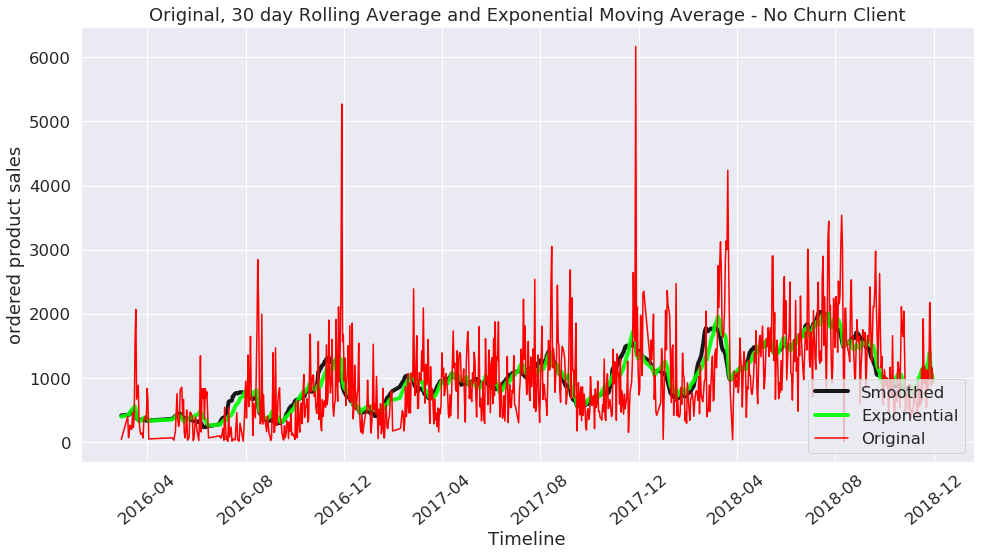

In [159]:
# 30 day moving average and exponential average plot for a no-churn client
fig = plt.figure(figsize=[16,8]);
ax = fig.add_subplot(111);
ax.plot(supplier_data["report_date"], rolling, color = (0,0,0), linewidth = 4, alpha = .9, label = 'Smoothed');
ax.plot(supplier_data["report_date"], rolling_ewm, color = (0,1,0), linewidth = 4, alpha = .9, label = 'Exponential');
ax.plot(supplier_data["report_date"], supplier_data["ordered_product_sales"], color = (1,0,0), label = 'Original');
ax.set_title('Original, 30 day Rolling Average and Exponential Moving Average - No Churn Client')
plt.xticks(rotation=40)
ax.set_xlabel('Timeline')
ax.set_ylabel('ordered product sales')
ax.legend(loc='lower right');


** The EWMA in green is more responsive to recent data points. It would be a good starting point if building a predictive model for churn. **

In [160]:
#30 day moving average for a churned client
#rolling averages for supplier_key 8
#supplier_data = df_sales.query("supplier_key == 8")
supplier_data = df_sales.query("supplier_key == 18 and ordered_product_sales >0")
rolling = supplier_data["ordered_product_sales"].rolling(window = 30).mean()
rolling_ewm = supplier_data["ordered_product_sales"].ewm(span=30, ignore_na=True).mean()
churn_data = df_churn.query("supplier_key == 18")
churn_date = churn_data["churn_date"].to_string(header=False, index=False)

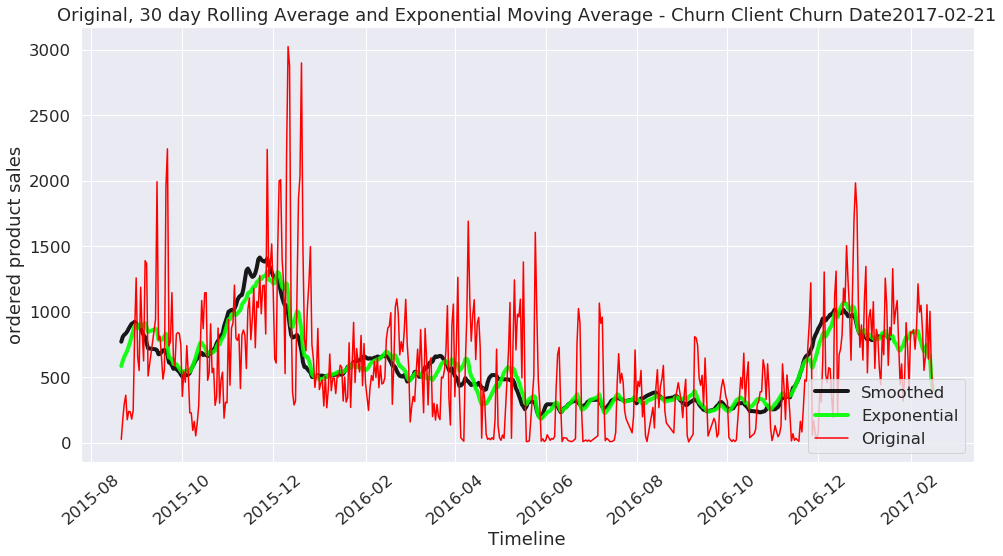

In [161]:
# 30 day moving average plot for a churn client
fig = plt.figure(figsize=[16,8]);
ax = fig.add_subplot(111);
ax.plot(supplier_data["report_date"], rolling, color = (0,0,0), linewidth = 4, alpha = .9, label = 'Smoothed');
ax.plot(supplier_data["report_date"], rolling_ewm, color = (0,1,0), linewidth = 4, alpha = .9, label = 'Exponential');
ax.plot(supplier_data["report_date"], supplier_data["ordered_product_sales"], color = (1,0,0), label = 'Original');
ax.set_title('Original, 30 day Rolling Average and Exponential Moving Average - Churn Client Churn Date' + churn_date)
plt.xticks(rotation=40)
ax.set_xlabel('Timeline')
ax.set_ylabel('ordered product sales')
ax.legend(loc='lower right');

The exponential moving average appears to be closer to the Original sales data. It is more responsive to more recent data while calcuating averages.


** The following features will be added to capture trend data: **
* mean and total sales value across entire history
* last 3 month mean and sales delta/change value 
* last 6 month mean and sales delta/change value
* last year mean and sales delta/change value
* previous 3, 6, 12 month relative strength indicator using EWMA

In [183]:
#this will add mean, variance and rsi information for the last 3 months, 6 months and year
df_to_classify = add_rolled_up_features(df_sales, df_churn, mean=True, aggregate=True, sales_delta=True, rsi=True)


/home/harrinac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


**Our rolled up sales data features...**

In [184]:
display_all(df_to_classify.T)

supplier_key               1        2        3            4        5    \
3_month_mean_sales     35207.9   2017.3  21730.9       518741  10405.8   
6_month_mean_sales     43223.2  2733.21    22538       418263  7337.33   
12_month_mean_sales    39162.1  2891.18    15545       387839  4635.18   
total_mean_sales       25037.7  4656.82  6017.42       210401  2292.12   
3_month_rsi            59.4022  51.1993  60.9754      10.5946  52.8968   
6_month_rsi            54.5903  54.6798  59.6978        21.19  47.5279   
12_month_rsi           49.8546  55.3526  50.0302      24.8491  48.6011   
3_month_total_sales     105624  6051.89  65192.7  1.55622e+06  31217.3   
6_month_total_sales     259339  16399.3   135228  2.50958e+06    44024   
12_month_total_sales    469945  34694.1   186540  4.65407e+06  55622.2   
total_sales             901358   135048   186540  5.26001e+06  64179.4   
3_month_sales_change  -31.2861 -41.5129 -6.91442      63.2363  143.757   
6_month_sales_change   23.1393 -10.3611  163.541      17.0245  279.576   
12_month_sales_change  49.8162 -57.7226        0      677.361  551.223   
churned                     No       No      Yes          Yes       No   

supplier_key                   6        7        8        9        10   \
3_month_mean_sales         85798.4  12358.6  1734.25   136047  17696.8   
6_month_mean_sales         61223.8  11281.2  2275.23  68259.7  15162.1   
12_month_mean_sales        56346.5  8625.75  4740.21  34129.9   8172.5   
total_mean_sales           62429.5  3255.13  6455.58  15752.2   3922.8   
3_month_rsi                51.7682  30.3099  51.5274  30.7511  49.1775   
6_month_rsi                51.4652  36.7496  52.9766  30.6177  44.9441   
12_month_rsi               50.8415   39.505  62.4701  30.6172  43.6828   
3_month_total_sales         257395  37075.9  5202.74   408142  53090.3   
6_month_total_sales         367343  67687.3  13651.4   409558  90972.5   
12_month_total_sales        676158   103509  56882.5   409558    98070   
total_sales            1.62317e+06   104164   187212   409558    98070   
3_month_sales_change       134.107  21.1182 -38.4192  28707.1  40.1458   
6_month_sales_change       18.9521  88.9561 -68.4223        0  1181.74   
12_month_sales_change      -21.762  15699.8 -55.0313        0        0   
churned                        Yes       No      Yes      Yes      Yes   

supplier_key               11       12       13       14       15   \
3_month_mean_sales     3067.92  1896.21  18856.7  11002.3  5928.09   
6_month_mean_sales     2254.61  1564.76    15142  6622.27  3389.21   
12_month_mean_sales    1127.31  2023.09  8133.88  3311.14  1696.26   
total_mean_sales       1328.36  1240.85  3615.06  1528.22   782.89   
3_month_rsi            62.0665  49.9507   51.667  46.7653  40.6164   
6_month_rsi            50.0352  53.1005  44.6883  42.3841  38.5824   
12_month_rsi                50  49.9522  42.9469   42.233  38.5155   
3_month_total_sales    9203.75  5688.62    56570  33006.8  17784.3   
6_month_total_sales    13527.7  9388.55  90852.1  39733.6  20335.2   
12_month_total_sales   13527.7  24277.1  97606.6  39733.6  20355.1   
total_sales            31880.5  42188.9  97606.6  39733.6  20355.1   
3_month_sales_change   112.857  53.7494   65.013  390.676  597.154   
6_month_sales_change         0  -36.941  1245.07        0   102087   
12_month_sales_change -26.2912  35.9078        0        0        0   
churned                    Yes      Yes      Yes      Yes       No   

supplier_key                   16       17       18       19       20   \
3_month_mean_sales         20522.8  2348.47  21663.7  8357.45  295.577   
6_month_mean_sales         22106.7  1981.38  14855.7  8523.67  502.347   
12_month_mean_sales        20820.6  1186.73  12900.1  6834.93   825.81   
total_mean_sales           21720.2  717.312  11210.2  2647.71  711.629   
3_month_rsi                52.0833  47.7585  53.0291  60.0974  55.1154   
6_month_rsi                52.0318  42.7883  47.4152  54.4301  55

**The 3/6/12_month_sales_change features along with the RSI will be used to test churn hypotheses.
the As the plot below shows this has a long tail. One option is to remove all records outside of the 75 percentile range. However our dataset is not large and so instead we will bin the values.
**

Text(0.5,1,'Percent Yearly Sales Change')

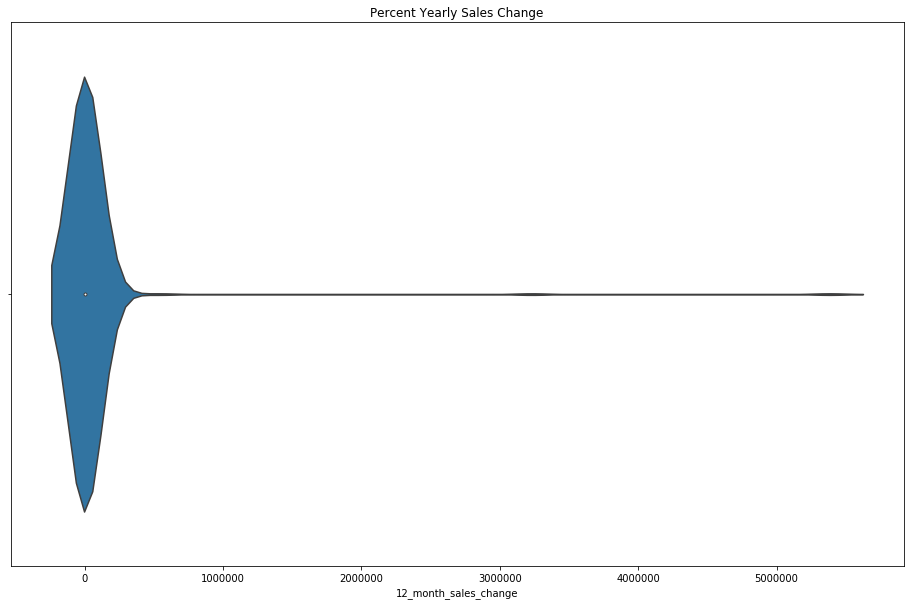

In [55]:
fig= plt.gcf()
fig.set_size_inches( 16, 10)
sns.violinplot(x=df_to_classify["12_month_sales_change"]).set_title("Percent Yearly Sales Change")

** The sales change percentages are binned as follows:**

In [185]:
bins = [-100,-10,-5, 5, 10, 10000000]
labels = ["sales_decline--","sales_decline-","sales_neutral","sales_increase+", "sales_increase++"]
df_to_classify["3_month_sales_bin"] = pd.cut(df_to_classify['3_month_sales_change'], bins=bins, labels=labels, right=False, include_lowest=True)
df_to_classify["6_month_sales_bin"] = pd.cut(df_to_classify['6_month_sales_change'], bins=bins, labels=labels, right=False, include_lowest=True)
df_to_classify["12_month_sales_bin"] = pd.cut(df_to_classify['12_month_sales_change'], bins=bins, labels=labels, right=False, include_lowest=True)

** Below we can see the binned 3,6,12 month sales change deltas. Now we have comprehensive rolled-up feature variables to test our hypotheses. **

In [186]:
display_all(df_to_classify.T)

supplier_key                        1                2                 3    \
3_month_mean_sales              35207.9           2017.3           21730.9   
6_month_mean_sales              43223.2          2733.21             22538   
12_month_mean_sales             39162.1          2891.18             15545   
total_mean_sales                25037.7          4656.82           6017.42   
3_month_rsi                     59.4022          51.1993           60.9754   
6_month_rsi                     54.5903          54.6798           59.6978   
12_month_rsi                    49.8546          55.3526           50.0302   
3_month_total_sales              105624          6051.89           65192.7   
6_month_total_sales              259339          16399.3            135228   
12_month_total_sales             469945          34694.1            186540   
total_sales                      901358           135048            186540   
3_month_sales_change           -31.2861         -41.5129          -6.91442   
6_month_sales_change            23.1393         -10.3611           163.541   
12_month_sales_change           49.8162         -57.7226                 0   
churned                              No               No               Yes   
3_month_sales_bin       sales_decline--  sales_decline--    sales_decline-   
6_month_sales_bin      sales_increase++  sales_decline--  sales_increase++   
12_month_sales_bin     sales_increase++  sales_decline--     sales_neutral   

supplier_key                        4                 5                 6    \
3_month_mean_sales               518741           10405.8           85798.4   
6_month_mean_sales               418263           7337.33           61223.8   
12_month_mean_sales              387839           4635.18           56346.5   
total_mean_sales                 210401           2292.12           62429.5   
3_month_rsi                     10.5946           52.8968           51.7682   
6_month_rsi                       21.19           47.5279           51.4652   
12_month_rsi                    24.8491           48.6011           50.8415   
3_month_total_sales         1.55622e+06           31217.3            257395   
6_month_total_sales         2.50958e+06             44024            367343   
12_month_total_sales        4.65407e+06           55622.2            676158   
total_sales                 5.26001e+06           64179.4       1.62317e+06   
3_month_sales_change            63.2363           143.757           134.107   
6_month_sales_change            17.0245           279.576           18.9521   
12_month_sales_change           677.361           551.223           -21.762   
churned                             Yes                No               Yes   
3_month_sales_bin      sales_increase++  sales_increase++  sales_increase++   
6_month_sales_bin      sales_increase++  sales_increase++  sales_increase++   
12_month_sales_bin     sales_increase++  sales_increase++   sales_decline--   

supplier_key                        7                8                 9    \
3_month_mean_sales              12358.6          1734.25            136047   
6_month_mean_sales              11281.2          2275.23           68259.7   
12_month_mean_sales             8625.75          4740.21           34129.9   
total_mean_sales                3255.13          6455.58           15752.2   
3_month_rsi                     30.3099          51.5274           30.7511   
6_month_rsi                     36.7496          52.9766           30.6177   
12_month_rsi                     39.505          62.4701           30.6172   
3_month_total_sales             37075.9          5202.74            408142   
6_month_total_sales             67687.3          13651.4            409558   
12_month_total_sales             103509          56882.5            409558   
total_sales                      104164           187212            409558   
3_month_sales_change            21.1182         -38.4192           28707.1   
6

# 3. Sales Data Visualization
** Now we have cleaned and chronologically ordered data. 
We have rolled-up the sales data and capture the trend information
Now we present some data visualizations to improve our understanding of the sales trend data.
**

**  Specifically we are interested in understanding if there is a correlation of trend movement to churn event and to verify customer service hypotheses: **

**1. Sales decline leads to end of business and churn.** 

** 2. Signififcant increases in sales lead to the client securing other financing options and churning.**

** As we see below there is a strong preponderance towards significant sales decline and significant growth over the previous 3 and 6 month periods for our customers. **
** Over a year's horizon length the sales performace is more balanced.** 
** As a result most churn events will fall into 1 of these 2 categories by frequency alone. **

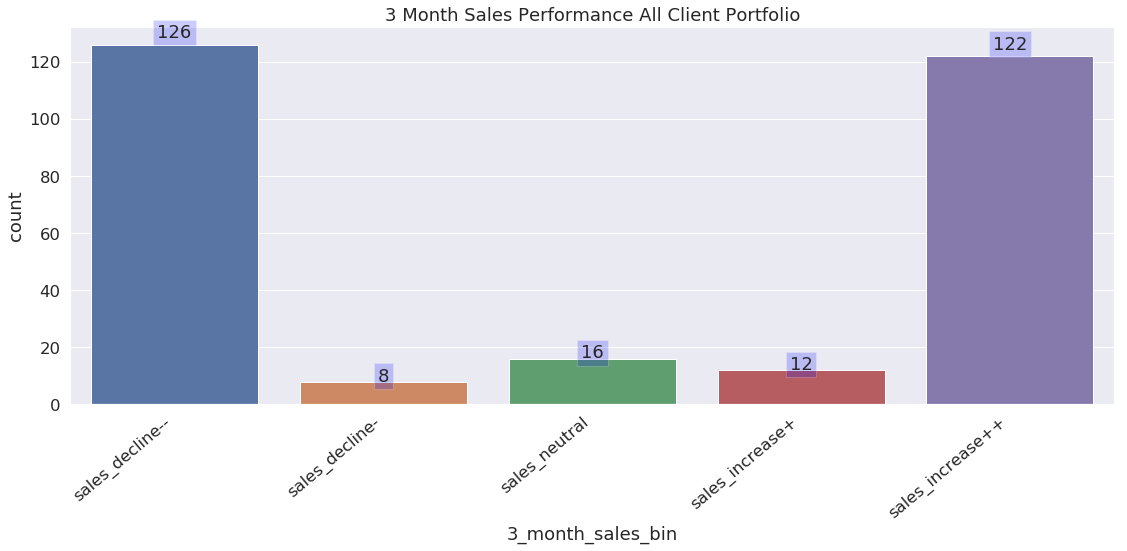

In [165]:
#categorical variable plots
sns.set(font_scale=1.5)
fig = plt.gcf()
fig.set_size_inches( 16, 8)    

ax = sns.countplot(x="3_month_sales_bin", data=df_to_classify) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("3 Month Sales Performance All Client Portfolio")

plt.tight_layout()

vals = df_to_classify["3_month_sales_bin"].value_counts()
for idx, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + height*.02,
            vals[idx], bbox=dict(facecolor='blue', alpha=0.2),
            ha="center")

** Let's visualize how churn status relates our sales performance metric**

<Figure size 1152x576 with 0 Axes>

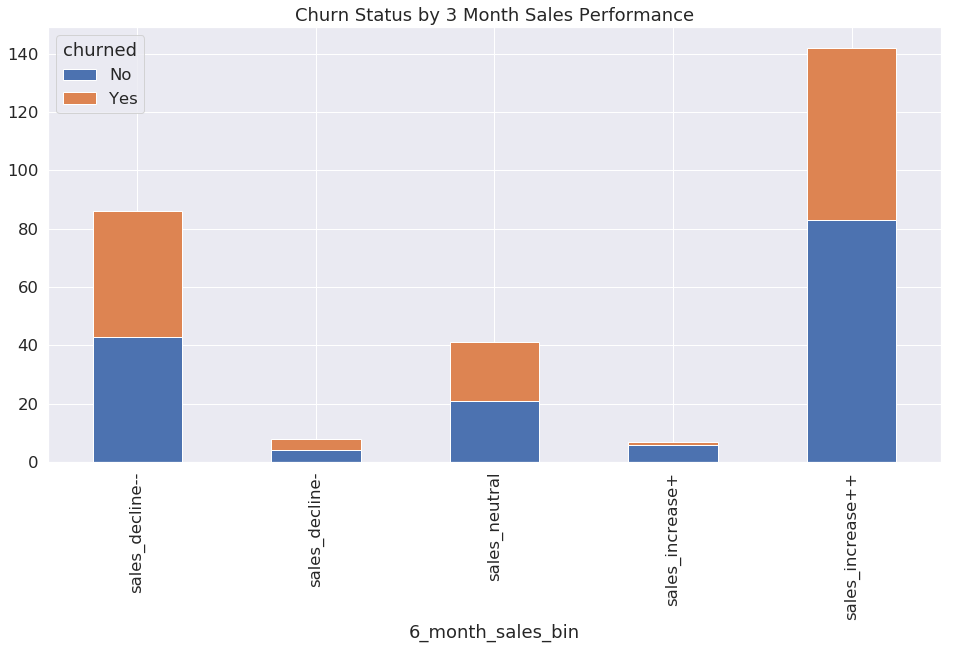

In [166]:
sns.set(font_scale=1.5)
fig = plt.gcf()
fig.set_size_inches( 16, 8)    

churn_3_month_performance_table = pd.crosstab(df_to_classify["6_month_sales_bin"], 
                          columns=df_to_classify["churned"], dropna=False)
churn_3_month_performance_table.plot(kind="bar", figsize=(16,8), stacked=True, title="Churn Status by 3 Month Sales Performance")

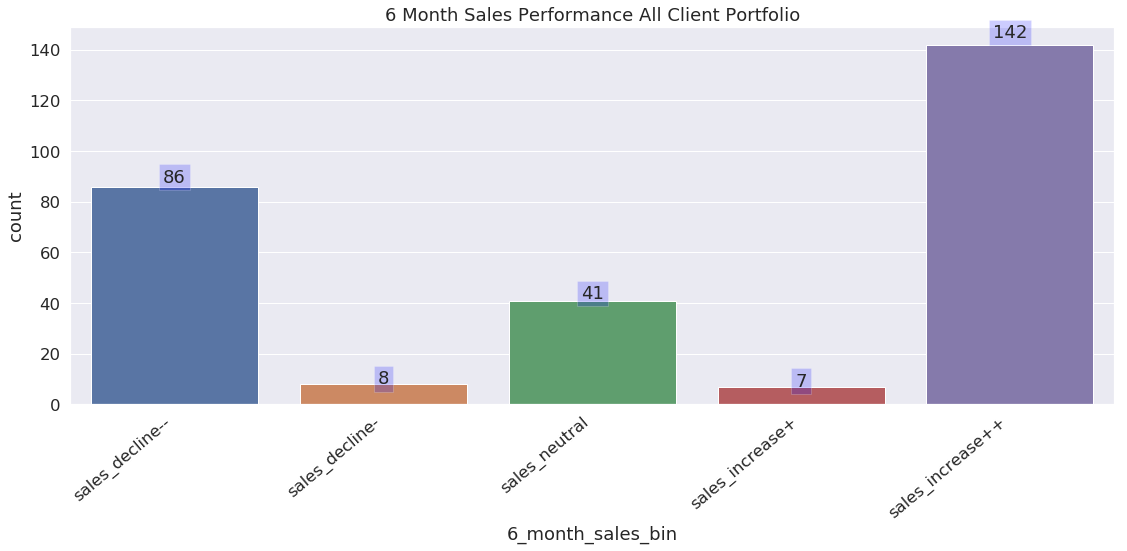

In [167]:
#categorical variable plots
sns.set(font_scale=1.5)
fig = plt.gcf()
fig.set_size_inches( 16, 8)    

ax = sns.countplot(x="6_month_sales_bin", data=df_to_classify) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("6 Month Sales Performance All Client Portfolio")

plt.tight_layout()

vals = df_to_classify["6_month_sales_bin"].value_counts()
for idx, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + height*.02,
            vals[idx], bbox=dict(facecolor='blue', alpha=0.2),
            ha="center")

<Figure size 1152x576 with 0 Axes>

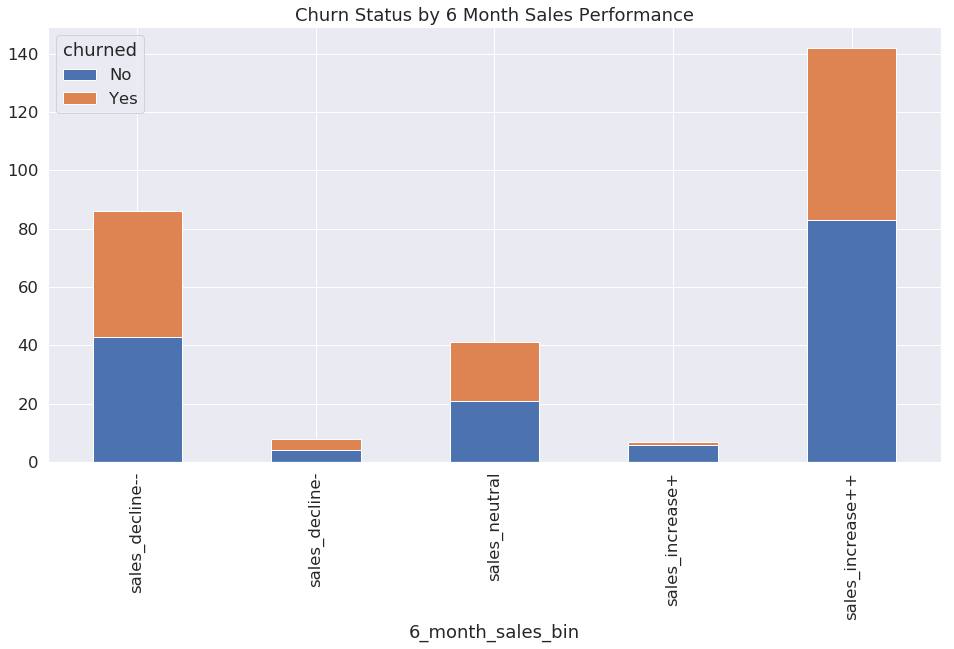

In [129]:
sns.set(font_scale=1.5)
fig = plt.gcf()
fig.set_size_inches( 16, 8)    

churn_6_month_performance_table = pd.crosstab(index=df_to_classify["6_month_sales_bin"], 
                          columns=df_to_classify["churned"], dropna=False)

churn_6_month_performance_table.plot(kind="bar", figsize=(16,8), stacked=True, title="Churn Status by 6 Month Sales Performance")

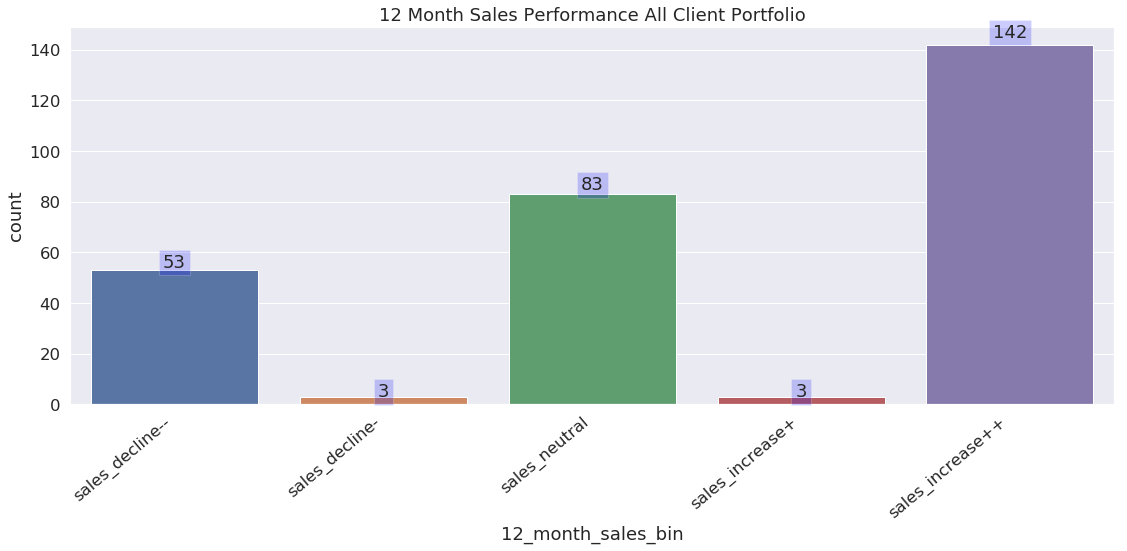

In [130]:
#categorical variable plots
sns.set(font_scale=1.5)
fig = plt.gcf()
fig.set_size_inches( 16, 8)    

ax = sns.countplot(x="12_month_sales_bin", data=df_to_classify) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("12 Month Sales Performance All Client Portfolio")

plt.tight_layout()

vals = df_to_classify["12_month_sales_bin"].value_counts()
for idx, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + height*.02,
            vals[idx], bbox=dict(facecolor='blue', alpha=0.2),
            ha="center")

<Figure size 1152x576 with 0 Axes>

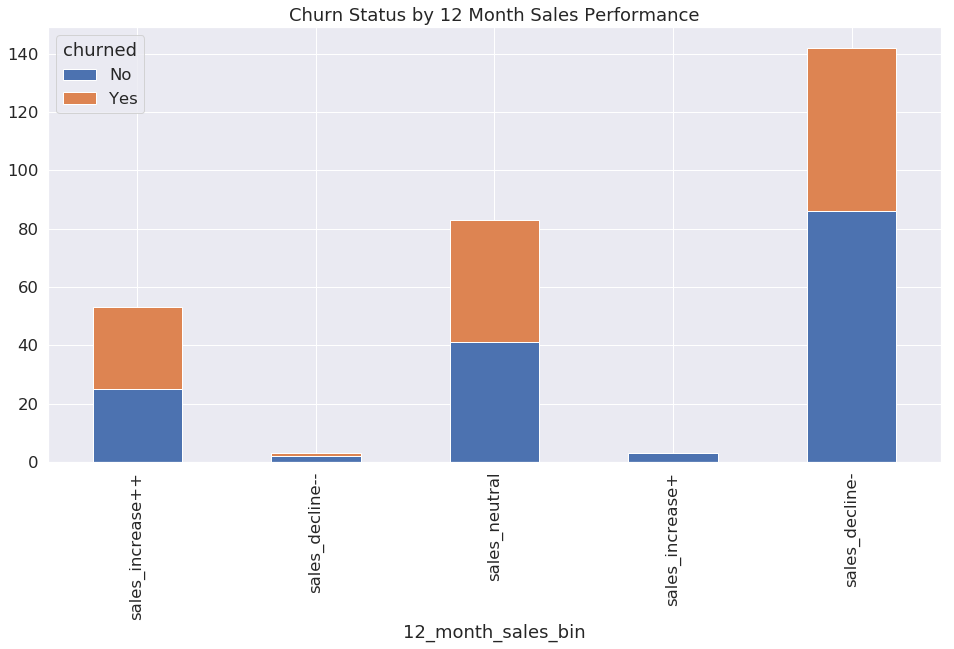

In [131]:
sns.set(font_scale=1.5)
fig = plt.gcf()
fig.set_size_inches( 16, 8)    

churn_3_month_performance_table = pd.crosstab(index=df_to_classify["12_month_sales_bin"], 
                          columns=df_to_classify["churned"])

churn_3_month_performance_table.plot(kind="bar", figsize=(16,8), stacked=True, title="Churn Status by 12 Month Sales Performance")

**If we plot sales momentum (higher RSI mean stronger sales growth and higher sales values) against
churned status we see that over a 3 month, 6 month and year period, higher RSI is consistently associated with churn status.
This is visual evidence in support of the second hypothesis.**
** In addition the RSI index is closer to the data. I created the sales performance bins manually and my assessment of strong/neutral sales performance is personal rather than being based on domain expertise.** 

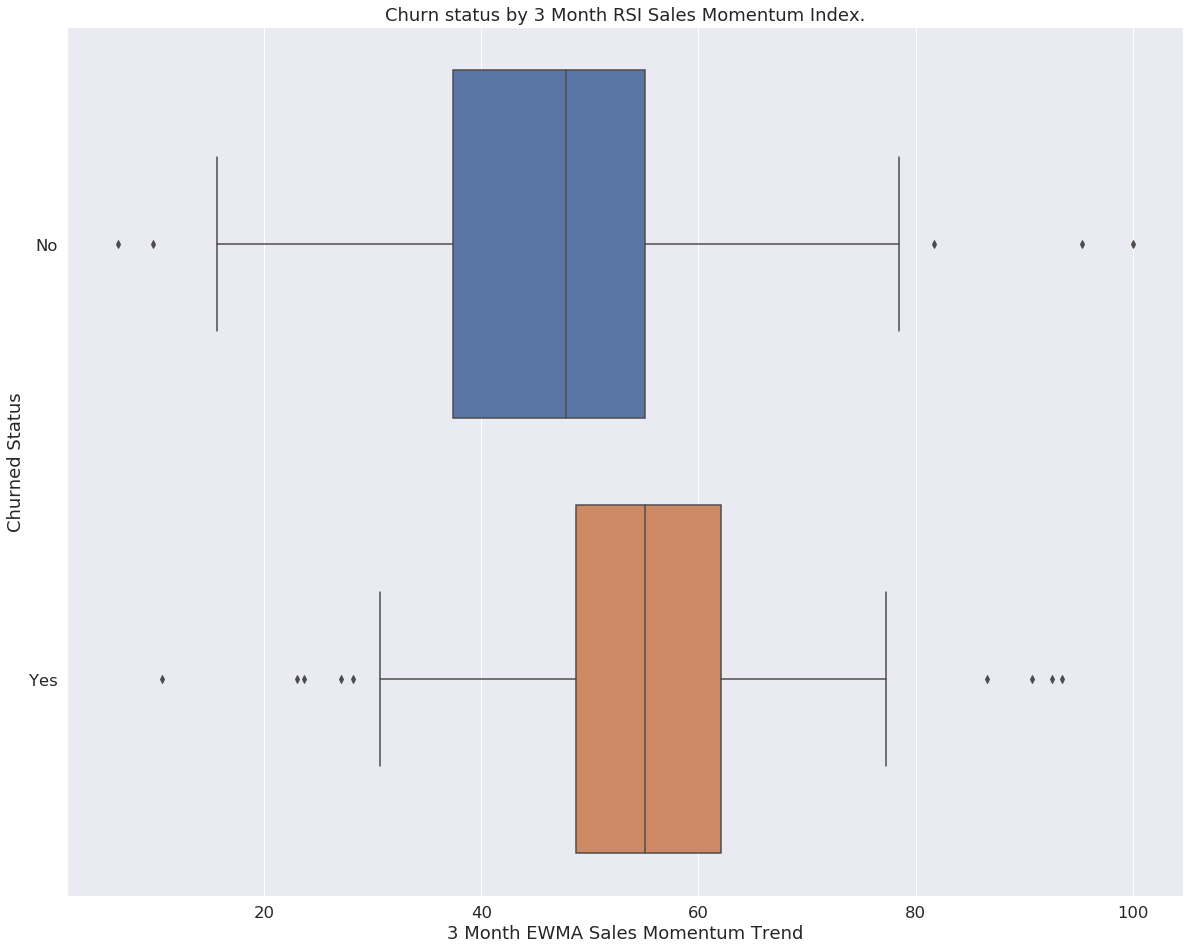

In [70]:
plt.figure(figsize=(20,16))
ax = sns.boxplot(y='churned', x='3_month_rsi', data=df_to_classify)
ax.set_title("Churn status by 3 Month RSI Sales Momentum Index.")
ax.set_xlabel('3 Month EWMA Sales Momentum Trend')
ax.set_ylabel('Churned Status')
plt.show()

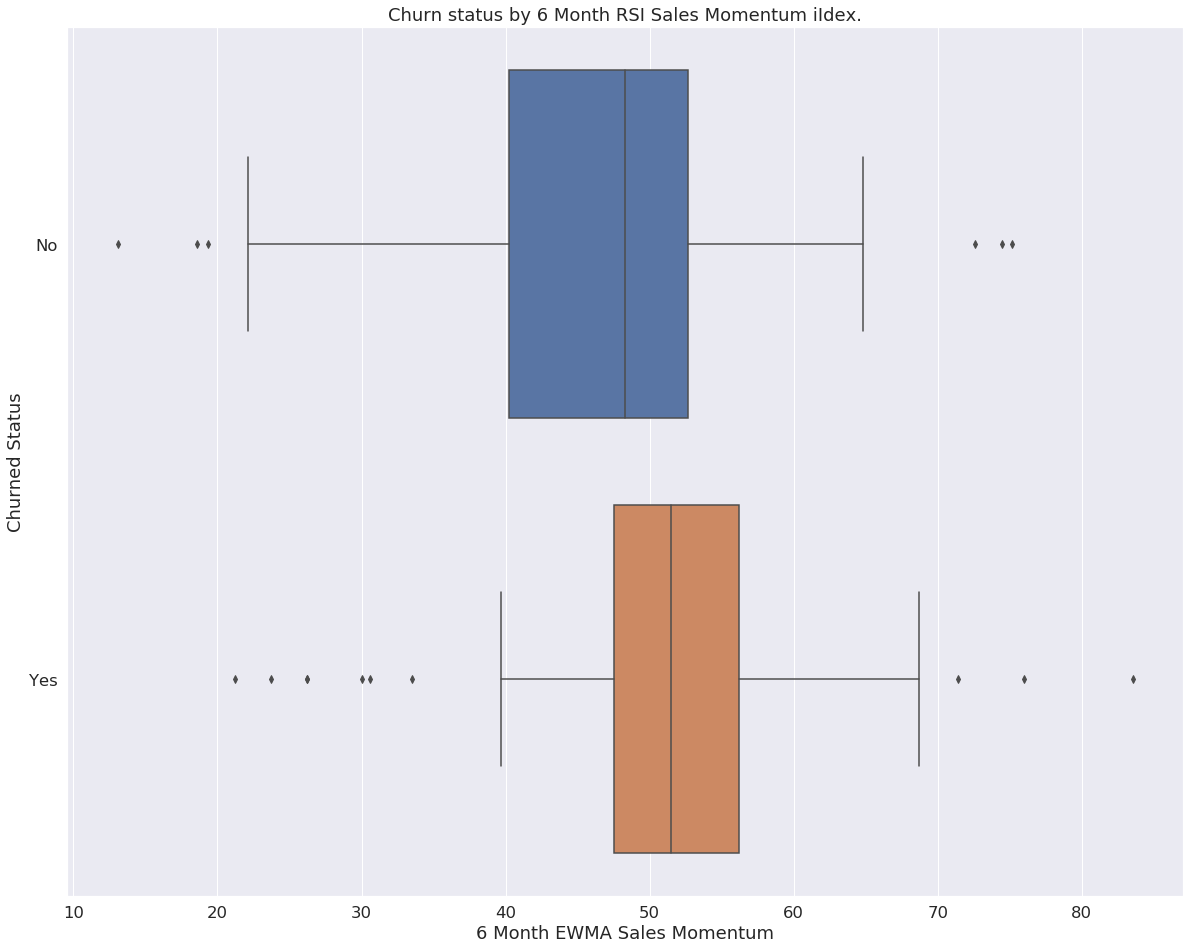

In [71]:
plt.figure(figsize=(20,16))
ax = sns.boxplot(y='churned', x='6_month_rsi', data=df_to_classify)
ax.set_title("Churn status by 6 Month RSI Sales Momentum iIdex.")
ax.set_xlabel('6 Month EWMA Sales Momentum')
ax.set_ylabel('Churned Status')
plt.show()

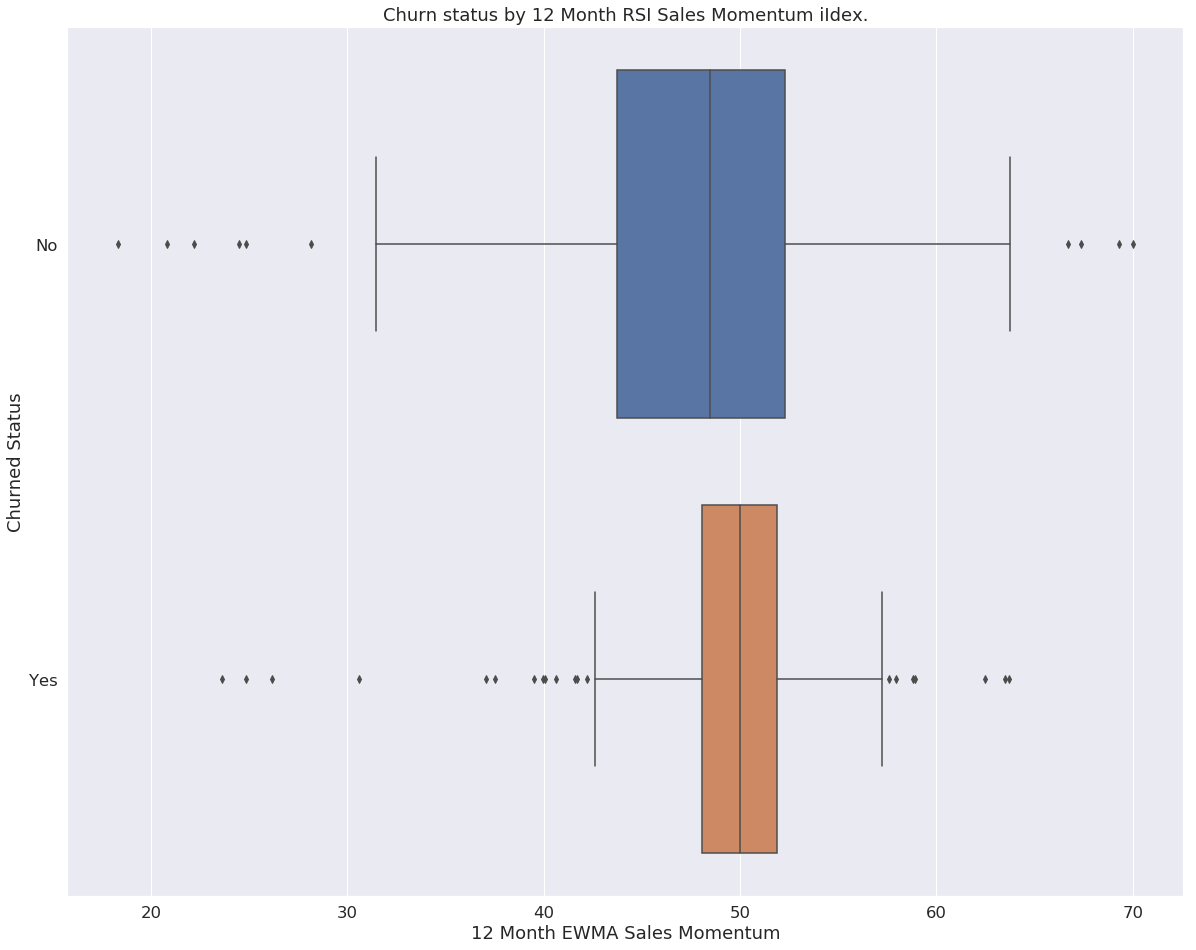

In [72]:
plt.figure(figsize=(20,16))
ax = sns.boxplot(y='churned', x='12_month_rsi', data=df_to_classify)
ax.set_title("Churn status by 12 Month RSI Sales Momentum iIdex.")
ax.set_xlabel('12 Month EWMA Sales Momentum')
ax.set_ylabel('Churned Status')
plt.show()

# 3. Export Data for Analysis


Sklearn algorithms require numerical data and so we do some last type conversion and save our data for analysis in notebook 2.

In [187]:
#Encode our binning labels as ordinal values - note this could have been done originally but would have been less readable
bin_status_dict={'sales_decline--':1,'sales_decline-':2, 'sales_neutral':3, 'sales_increase+':4, 'sales_increase++':5}
df_to_classify["3_month_sales_performance"]=pd.to_numeric(df_to_classify["3_month_sales_bin"].apply(bin_status_dict.get))
df_to_classify["6_month_sales_performance"]=pd.to_numeric(df_to_classify["6_month_sales_bin"].apply(bin_status_dict.get))
df_to_classify["12_month_sales_performance"]=pd.to_numeric(df_to_classify["12_month_sales_bin"].apply(bin_status_dict.get))
                 

In [188]:
df_to_classify.drop(["3_month_sales_bin", "6_month_sales_bin", "12_month_sales_bin"], axis=1, inplace=True)

In [189]:
churn_status_dict={'No':0,'Yes':1}
df_to_classify["churned"]=pd.to_numeric(df_to_classify["churned"].apply(churn_status_dict.get), downcast='integer')


In [190]:
df_to_classify.dtypes

3_month_mean_sales            float64
6_month_mean_sales            float64
12_month_mean_sales           float64
total_mean_sales              float64
3_month_rsi                   float64
6_month_rsi                   float64
12_month_rsi                  float64
3_month_total_sales           float64
6_month_total_sales           float64
12_month_total_sales          float64
total_sales                   float64
3_month_sales_change          float64
6_month_sales_change          float64
12_month_sales_change         float64
churned                          int8
3_month_sales_performance       int64
6_month_sales_performance       int64
12_month_sales_performance      int64
dtype: object

In [191]:
display_all(df_to_classify.T)

supplier_key                          1              2              3    \
3_month_mean_sales           35207.890000    2017.296667   21730.913333   
6_month_mean_sales           43223.153333    2733.215000   22538.001667   
12_month_mean_sales          39162.090000    2891.177500   15544.989167   
total_mean_sales             25037.718056    4656.819310    6017.415161   
3_month_rsi                     59.402215      51.199289      60.975426   
6_month_rsi                     54.590301      54.679760      59.697783   
12_month_rsi                    49.854621      55.352611      50.030151   
3_month_total_sales         105623.670000    6051.890000   65192.740000   
6_month_total_sales         259338.920000   16399.290000  135228.010000   
12_month_total_sales        469945.080000   34694.130000  186539.870000   
total_sales                 901357.850000  135047.760000  186539.870000   
3_month_sales_change           -31.286148     -41.512940      -6.914416   
6_month_sales_change            23.139285     -10.361118     163.541431   
12_month_sales_change           49.816188     -57.722603       0.000000   
churned                          0.000000       0.000000       1.000000   
3_month_sales_performance        1.000000       1.000000       2.000000   
6_month_sales_performance        5.000000       1.000000       5.000000   
12_month_sales_performance       5.000000       1.000000       3.000000   

supplier_key                         4             5             6    \
3_month_mean_sales          5.187406e+05  10405.756667  8.579840e+04   
6_month_mean_sales          4.182628e+05   7337.333333  6.122378e+04   
12_month_mean_sales         3.878389e+05   4635.183333  5.634652e+04   
total_mean_sales            2.104006e+05   2292.120357  6.242949e+04   
3_month_rsi                 1.059459e+01     52.896810  5.176815e+01   
6_month_rsi                 2.119003e+01     47.527916  5.146518e+01   
12_month_rsi                2.484911e+01     48.601078  5.084153e+01   
3_month_total_sales         1.556222e+06  31217.270000  2.573952e+05   
6_month_total_sales         2.509577e+06  44024.000000  3.673427e+05   
12_month_total_sales        4.654066e+06  55622.200000  6.761582e+05   
total_sales                 5.260014e+06  64179.370000  1.623167e+06   
3_month_sales_change        6.323634e+01    143.756759  1.341073e+02   
6_month_sales_change        1.702445e+01    279.576141  1.895214e+01   
12_month_sales_change       6.773609e+02    551.223073 -2.176199e+01   
churned                     1.000000e+00      0.000000  1.000000e+00   
3_month_sales_performance   5.000000e+00      5.000000  5.000000e+00   
6_month_sales_performance   5.000000e+00      5.000000  5.000000e+00   
12_month_sales_performance  5.000000e+00      5.000000  1.000000e+00   

supplier_key                          7              8              9    \
3_month_mean_sales           12358.643333    1734.246667  136047.193333   
6_month_mean_sales           11281.216667    2275.230000   68259.731667   
12_month_mean_sales           8625.750000    4740.205000   34129.865833   
total_mean_sales              3255.129063    6455.580345   15752.245769   
3_month_rsi                     30.309860      51.527355      30.751079   
6_month_rsi                     36.749592      52.976618      30.617725   
12_month_rsi                    39.505032      62.470106      30.617166   
3_month_total_sales          37075.930000    5202.740000  408141.580000   
6_month_total_sales          67687.300000   13651.380000  409558.390000   
12_month_total_sales        103509.000000   56882.460000  409558.390000   
total_sales                 104164.130000  187211.830000  409558.390000   
3_month_sales_change            21.118166     -38.419201   28707.079284   
6_month_sales_change            88.956136     -68.422302       0.000000   
12_month_sales_change        15699.764932     -55.031268       0.000000   
churned                          0.000000       1.000000       1.000000   
3_mon

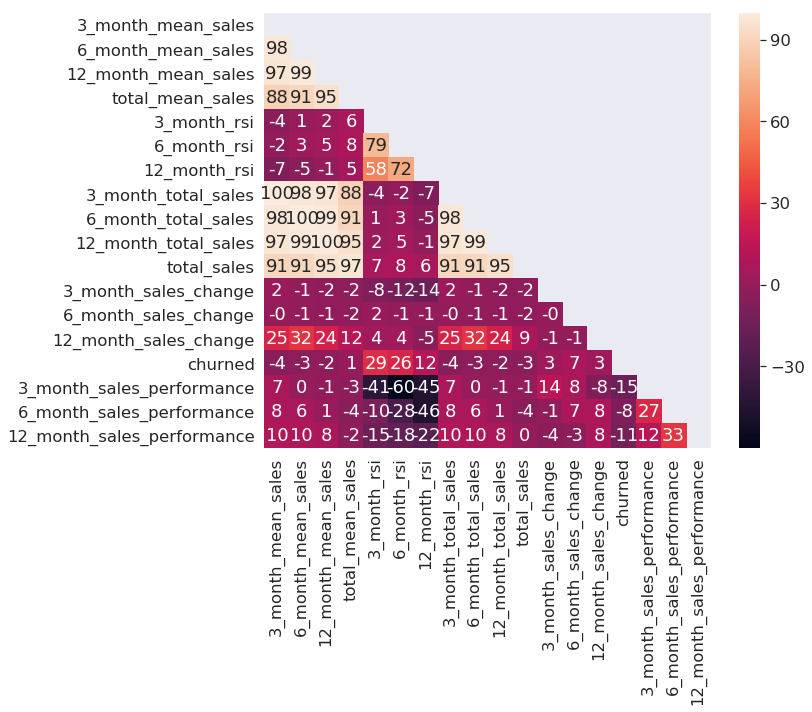

In [198]:
# Check how the correlation data looks

# The rsi and sales performance data are weakly negatively correlated
# The binning of the sales performance data make this less interesting.
correlations = df_to_classify.corr()

mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Make the figsize 10 x 8
plt.figure(figsize=(10,8))

# Plot heatmap of correlations
sns.heatmap(correlations * 100, annot=True, fmt='.0f', mask=mask)


Finish and save the analytical base table for analysis in notebook 2.

In [199]:
df_to_classify.to_csv('data/churn_analytical_base_table.csv')